# Compare surface freshwater state between ANHA4 experiments with different river forcing.

- ANHA4-EPM015 --- Dai and Trenberth river forcing, CGRF atmospheric forcing
- ANHA4-EPM101 --- HYPE river forcing, CGRF atmospheric forcing

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

%matplotlib inline

#### Parameters

In [2]:
# Domain dimensions ANHA12:
imin_ANHA12, imax_ANHA12 = 1479, 2179
jmin_ANHA12, jmax_ANHA12 = 159, 799
isize_ANHA12 = imax_ANHA12 - imin_ANHA12
jsize_ANHA12 = jmax_ANHA12 - jmin_ANHA12

# Domain dimensions ANHA4: (50, 800, 544)
imin_ANHA4, imax_ANHA4 = 500, 680
jmin_ANHA4, jmax_ANHA4 = 60, 260
isize_ANHA4 = imax_ANHA4 - imin_ANHA4
jsize_ANHA4 = jmax_ANHA4 - jmin_ANHA4

# Folders:
folder_HYPE = '/data/brogalla/ANHA4/ANHA4-EPM101/'
folder_Dai  = '/data/brogalla/ANHA4/ANHA4-EPM015/'

#### Load files

In [3]:
ANHA4_mesh   = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EPM101/ANHA4-EPM101_y2008m05d05_gridT.nc')
ANHA4_lon    = np.array(ANHA4_mesh.variables['nav_lon_grid_T'])
ANHA4_lat    = np.array(ANHA4_mesh.variables['nav_lat_grid_T'])
ANHA4_e3t    = np.array(ANHA4_mesh.variables['e3t'])[0,:,:,:] 
ANHA4_e3t_ma = np.ma.masked_where(ANHA4_e3t > 1e4, ANHA4_e3t)
ANHA4_depth  = np.ma.cumsum(ANHA4_e3t_ma, axis=0)

In [4]:
month=5
file_stub_HYPE = f'ANHA4-EPM101_monthly_2008{month:02}.nc'
file_stub_Dai  = f'ANHA4-EPM015_monthly_2008{month:02}.nc'
    
path_HYPE = f'{folder_HYPE}{file_stub_HYPE}'
path_Dai  = f'{folder_Dai}{file_stub_Dai}'

HYPE = xr.open_dataset(f'{path_HYPE}')
Dai  = xr.open_dataset(f'{path_Dai}')

In [5]:
# Meshmasks
mask_ANHA4  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA4_mask.nc')
tmask_ANHA4 = np.array(mask_ANHA4.variables['tmask'])[0,:,:,:]
gdept_ANHA4 = np.array(mask_ANHA4.variables['gdept_0'])

mesh_ANHA4   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA4_mesh_zgr.nc')
mbathy_ANHA4 = np.array(mesh_ANHA4.variables['mbathy'])[0,:,:]  # index of bottom grid cell
# land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

#### Functions

In [6]:
def load_results(month):
    
    file_stub_HYPE = f'ANHA4-EPM101_monthly_2008{month:02}.nc'
    file_stub_Dai  = f'ANHA4-EPM015_monthly_2008{month:02}.nc'
    
    HYPE = xr.open_dataset(f'{folder_HYPE}{file_stub_HYPE}')
    Dai  = xr.open_dataset(f'{folder_Dai}{file_stub_Dai}')
    
    HYPE_salinity = HYPE['vosaline'].values[0,:,:,:]
    Dai_salinity  = Dai['vosaline'].values[0,:,:,:]  
    
    return HYPE_salinity, Dai_salinity

In [7]:
HYPE_salinity_series = np.empty((4,50,800,544))
Dai_salinity_series  = np.empty((4,50,800,544))

for ind, month in enumerate(range(5,9)):
    HYPE_salinity, Dai_salinity     = load_results(month) # load monthly results month 5-9
    HYPE_salinity_series[ind,:,:,:] = HYPE_salinity
    Dai_salinity_series[ind,:,:,:]  = Dai_salinity

Mask places outside of domain and CAA:

In [8]:
# Mask for the CAA region:  1 for the CAA, 0 elsewhere              
mask_CAA = np.zeros(ANHA4_lon.shape)
mask_CAA[imin_ANHA4:imax_ANHA4, jmin_ANHA4:jmax_ANHA4] = 1
mask_CAA[(ANHA4_lat > 84) & (ANHA4_lat < 65) & (ANHA4_lon > -62) & (ANHA4_lon < -130)] = 0
mask_CAA[mbathy_ANHA4 > 33] = 0 # mask deeper than 763 m
mask_CAA[tmask_ANHA4[0,:,:] == 0] = 0 # mask where land

# Mask lons and lats based on CAA:
ANHA4_lon_ma = np.ma.masked_where(mask_CAA == 0, ANHA4_lon)
ANHA4_lat_ma = np.ma.masked_where(mask_CAA == 0, ANHA4_lat)

mask_CAA_grid = np.broadcast_to(mask_CAA, (4,50,800,544))
Dai_salinity_series_ma  = np.ma.masked_where(mask_CAA_grid == 0, Dai_salinity_series)
HYPE_salinity_series_ma = np.ma.masked_where(mask_CAA_grid == 0, HYPE_salinity_series)

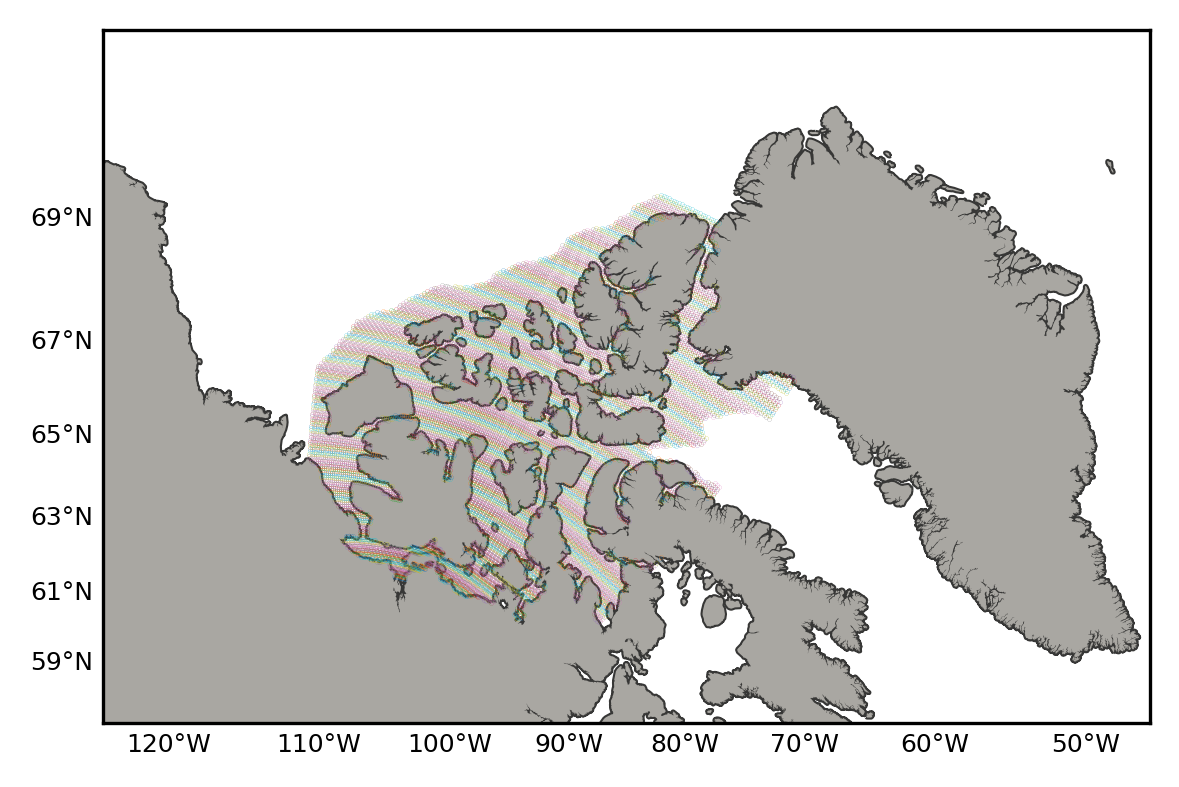

In [20]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x_ANHA4, y_ANHA4 = proj1(ANHA4_lon_ma, ANHA4_lat_ma)

proj1.plot(x_ANHA4, y_ANHA4, '.', markersize=0.1);

#### Figures

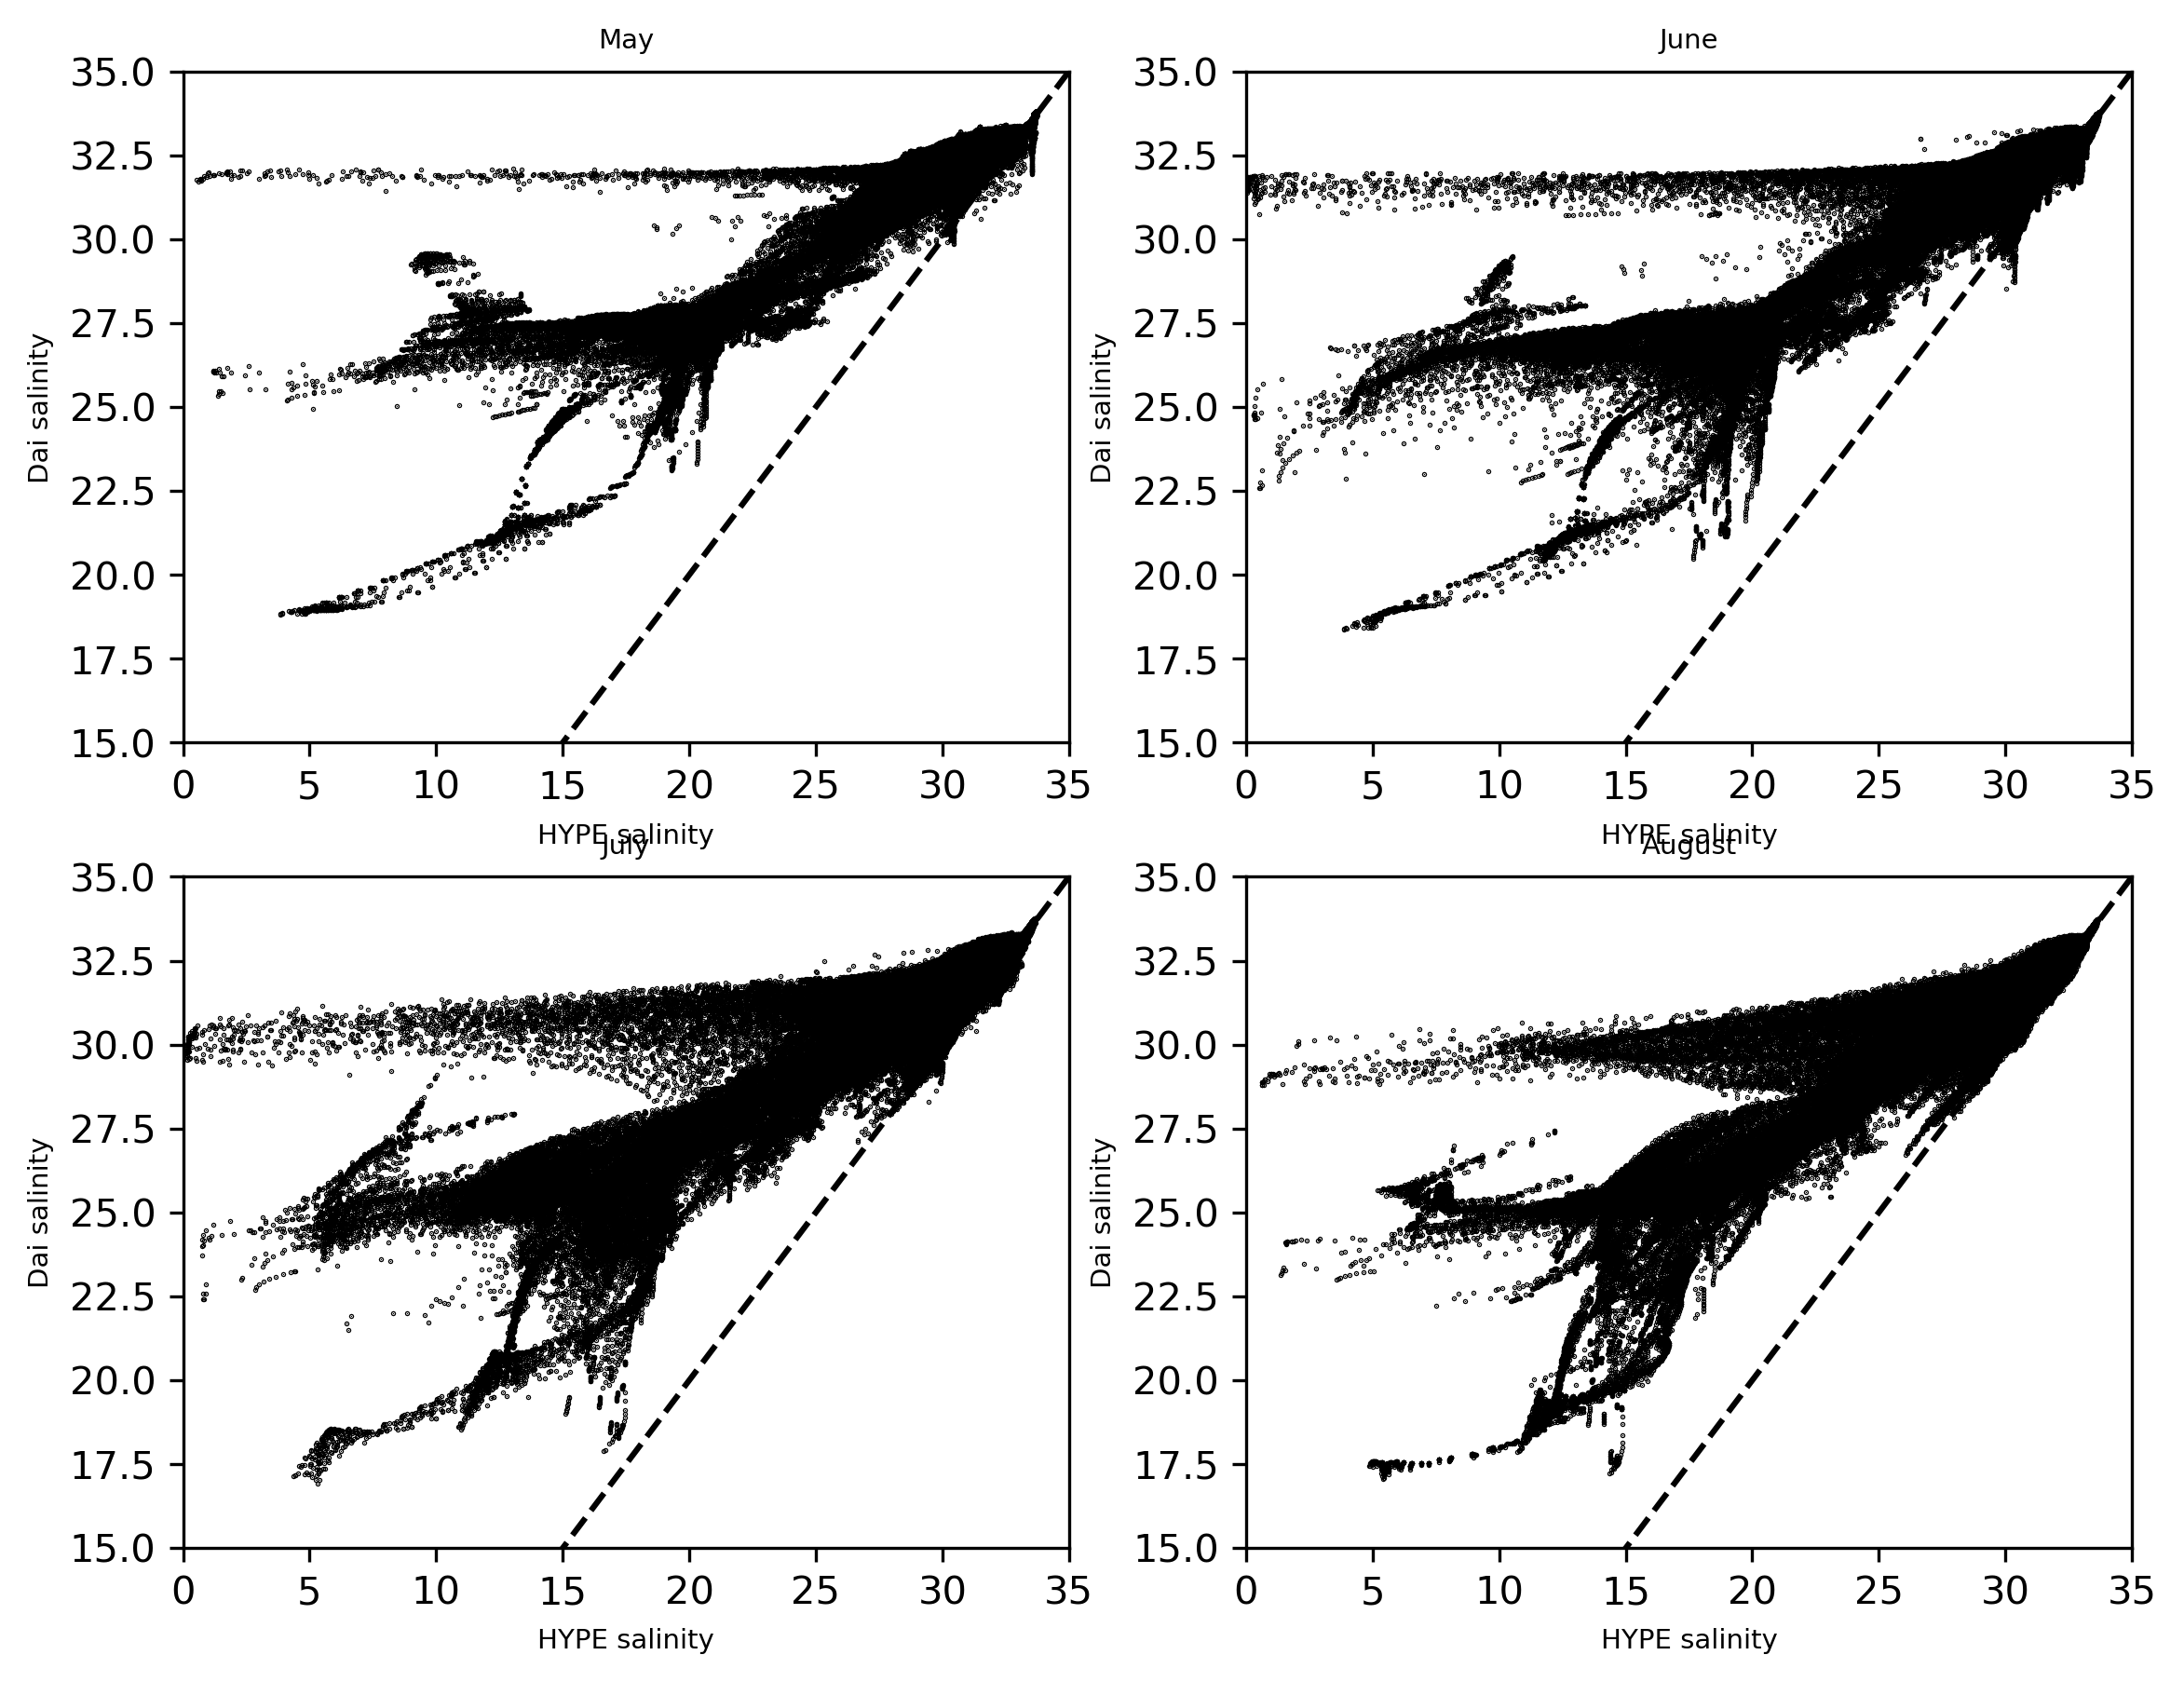

In [22]:
# Correlate surface salinity between the two experiments for the four summer months
fig, ax = plt.subplots(2, 2, figsize=(9, 7), dpi=300)

ax[0,0].set_title('May'   , fontsize=7)
ax[0,1].set_title('June'  , fontsize=7)
ax[1,0].set_title('July'  , fontsize=7)
ax[1,1].set_title('August', fontsize=7)

for ind, axis in enumerate(ax.ravel()):
    axis.plot(HYPE_salinity_series_ma[ind,0:17,:,:].compressed(), Dai_salinity_series_ma[ind, 0:17,:,:].compressed(), \
              '.k', markersize=0.6)
    axis.plot([0,50],[0,50], '--k')
    
    axis.set_xlim(0,35)
    axis.set_ylim(15,35)
    axis.set_xlabel('HYPE salinity', fontsize=7)
    axis.set_ylabel('Dai salinity', fontsize=7)

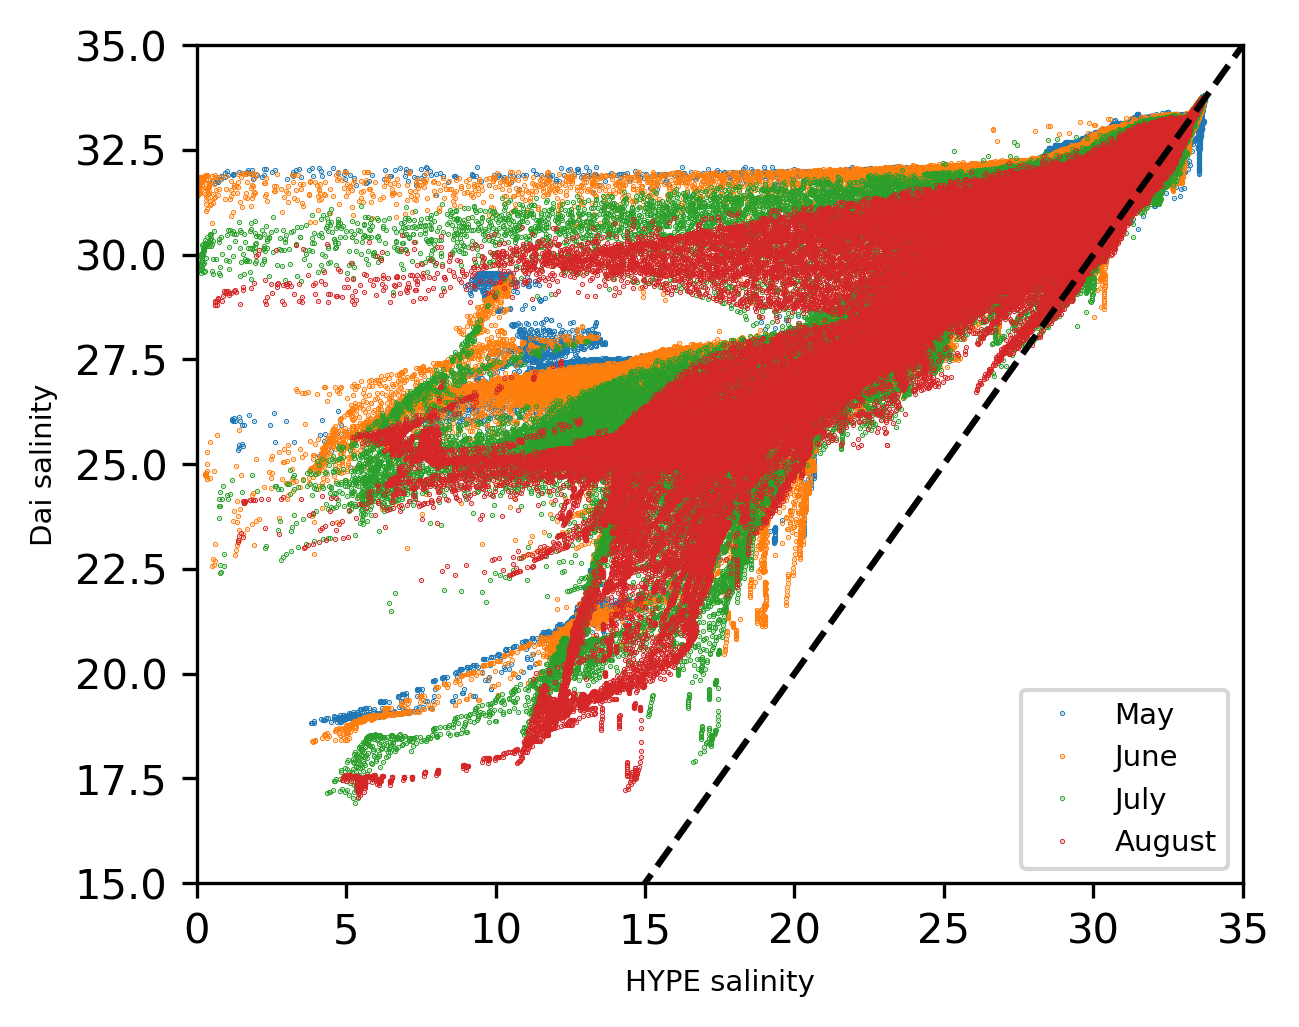

In [23]:
# Correlate surface salinity between the two experiments for the four summer months
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7), dpi=300)

months=['May', 'June', 'July', 'August']

for ind, month in enumerate(range(5,9)):
    ax.plot(HYPE_salinity_series_ma[ind,0:17,:,:].compressed(), Dai_salinity_series_ma[ind, 0:17,:,:].compressed(), \
            '.', markersize=0.5, label=months[ind])
    
ax.plot([0,50],[0,50], '--k')

ax.set_xlim(0,35)
ax.set_ylim(15,35)
ax.set_xlabel('HYPE salinity', fontsize=7)
ax.set_ylabel('Dai salinity', fontsize=7)
ax.legend(fontsize=7)

In [10]:
# Mask zero values
HYPE_salinity_series_ma0 = np.ma.masked_where(HYPE_salinity_series == 0, HYPE_salinity_series_ma)
Dai_salinity_series_ma0  = np.ma.masked_where(Dai_salinity_series == 0, Dai_salinity_series_ma)

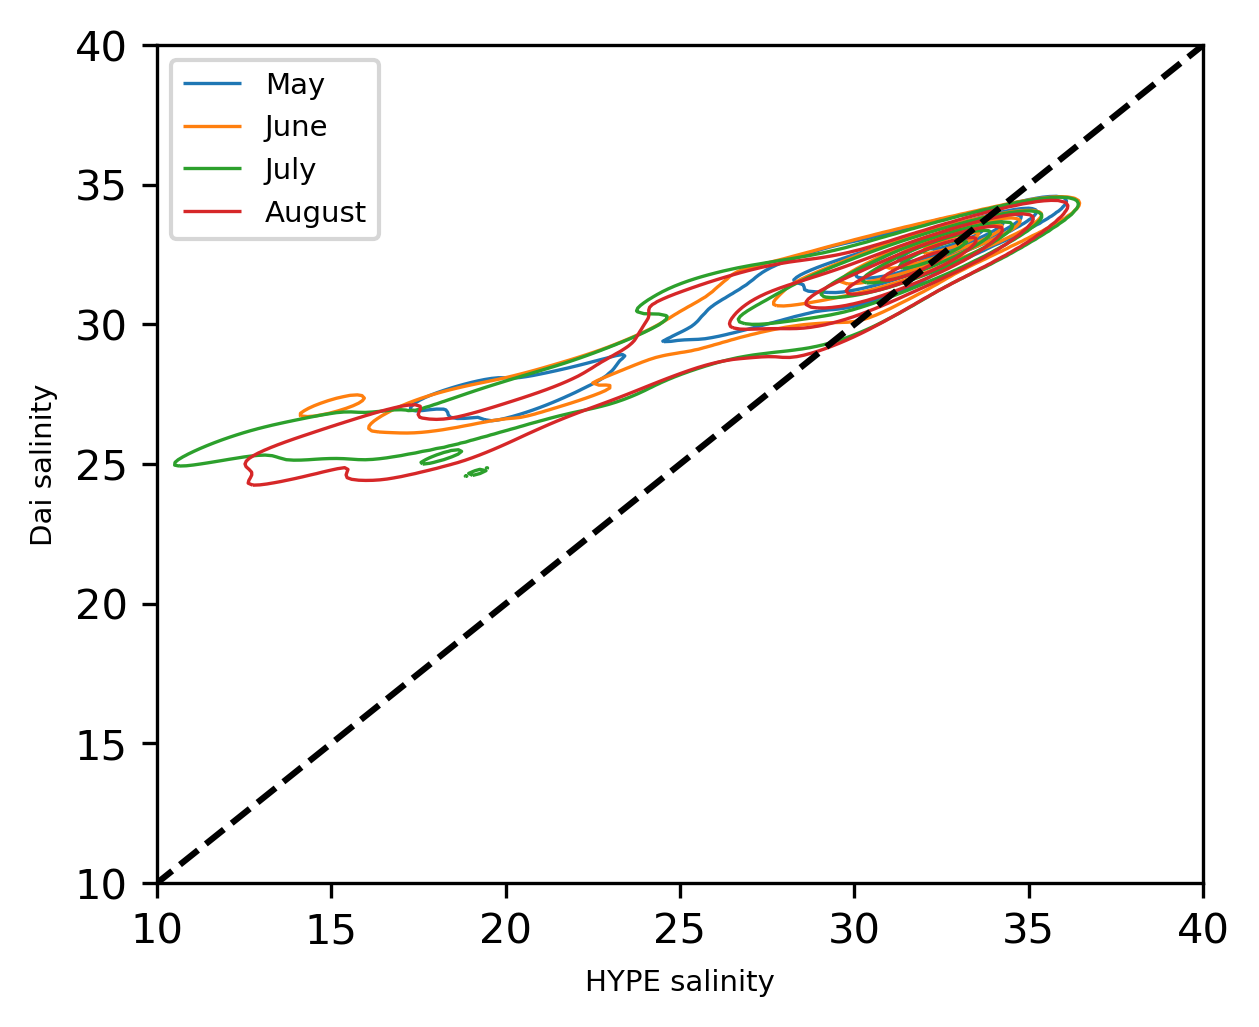

In [30]:
# Correlate surface salinity between the two experiments for the four summer months
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7), dpi=300)

months=['May', 'June', 'July', 'August']

ax.plot([0,50],[0,50], '--k')

reso = 5
for ind, month in enumerate(range(5,9)):
    sns.kdeplot(x=HYPE_salinity_series_ma0[ind,0:17,::reso,::reso].compressed(), \
                y=Dai_salinity_series_ma0[ind,0:17, ::reso,::reso].compressed(), \
                ax=ax, label=months[ind], linewidths=0.8, levels=[0.1, 0.3, 0.5, 0.7, 0.9])
    
ax.set_xlim(10,40)
ax.set_ylim(10,40)
ax.set_xlabel('HYPE salinity', fontsize=7)
ax.set_ylabel('Dai salinity', fontsize=7)
ax.legend(loc=2, fontsize=7)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  **contour_kws,


Text(0, 0.5, 'Dai salinity')

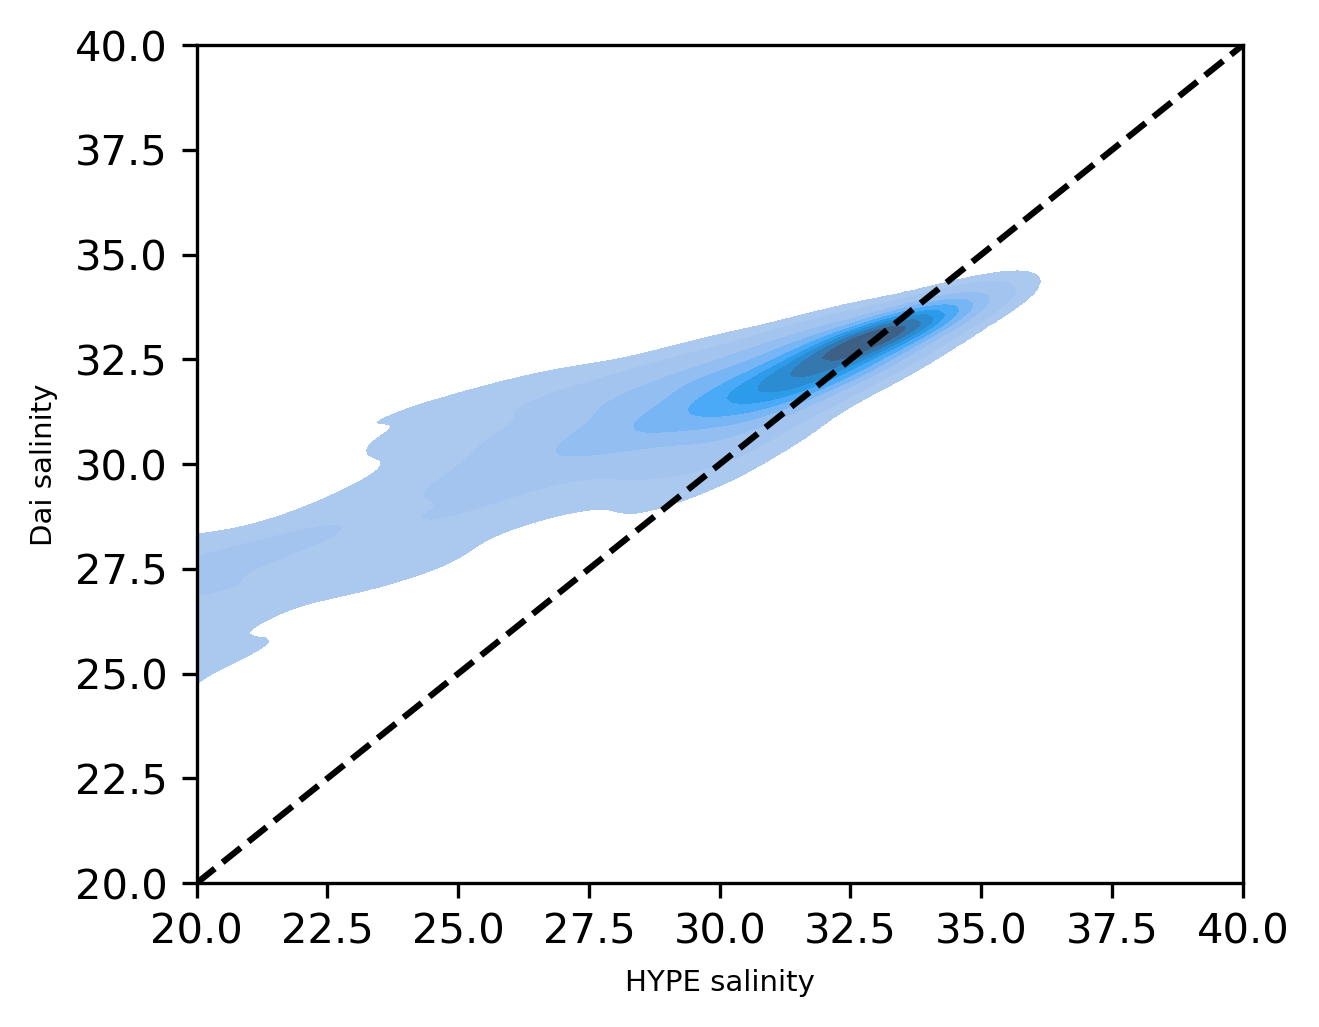

In [28]:
# Correlate surface salinity between the two experiments for the four summer months
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7), dpi=300)

ax.plot([0,50],[0,50], '--k')

reso = 5
sns.kdeplot(x=HYPE_salinity_series_ma0[:,0:17,::reso,::reso].compressed(), \
            y=Dai_salinity_series_ma0[:,0:17, ::reso,::reso].compressed(), \
            ax=ax, label=months[ind], linewidths=0.8, fill=True)
    
ax.set_xlim(20,40)
ax.set_ylim(20,40)
ax.set_xlabel('HYPE salinity', fontsize=7)
ax.set_ylabel('Dai salinity', fontsize=7)

### Maps

Text(0.5, 0.98, 'HYPE')

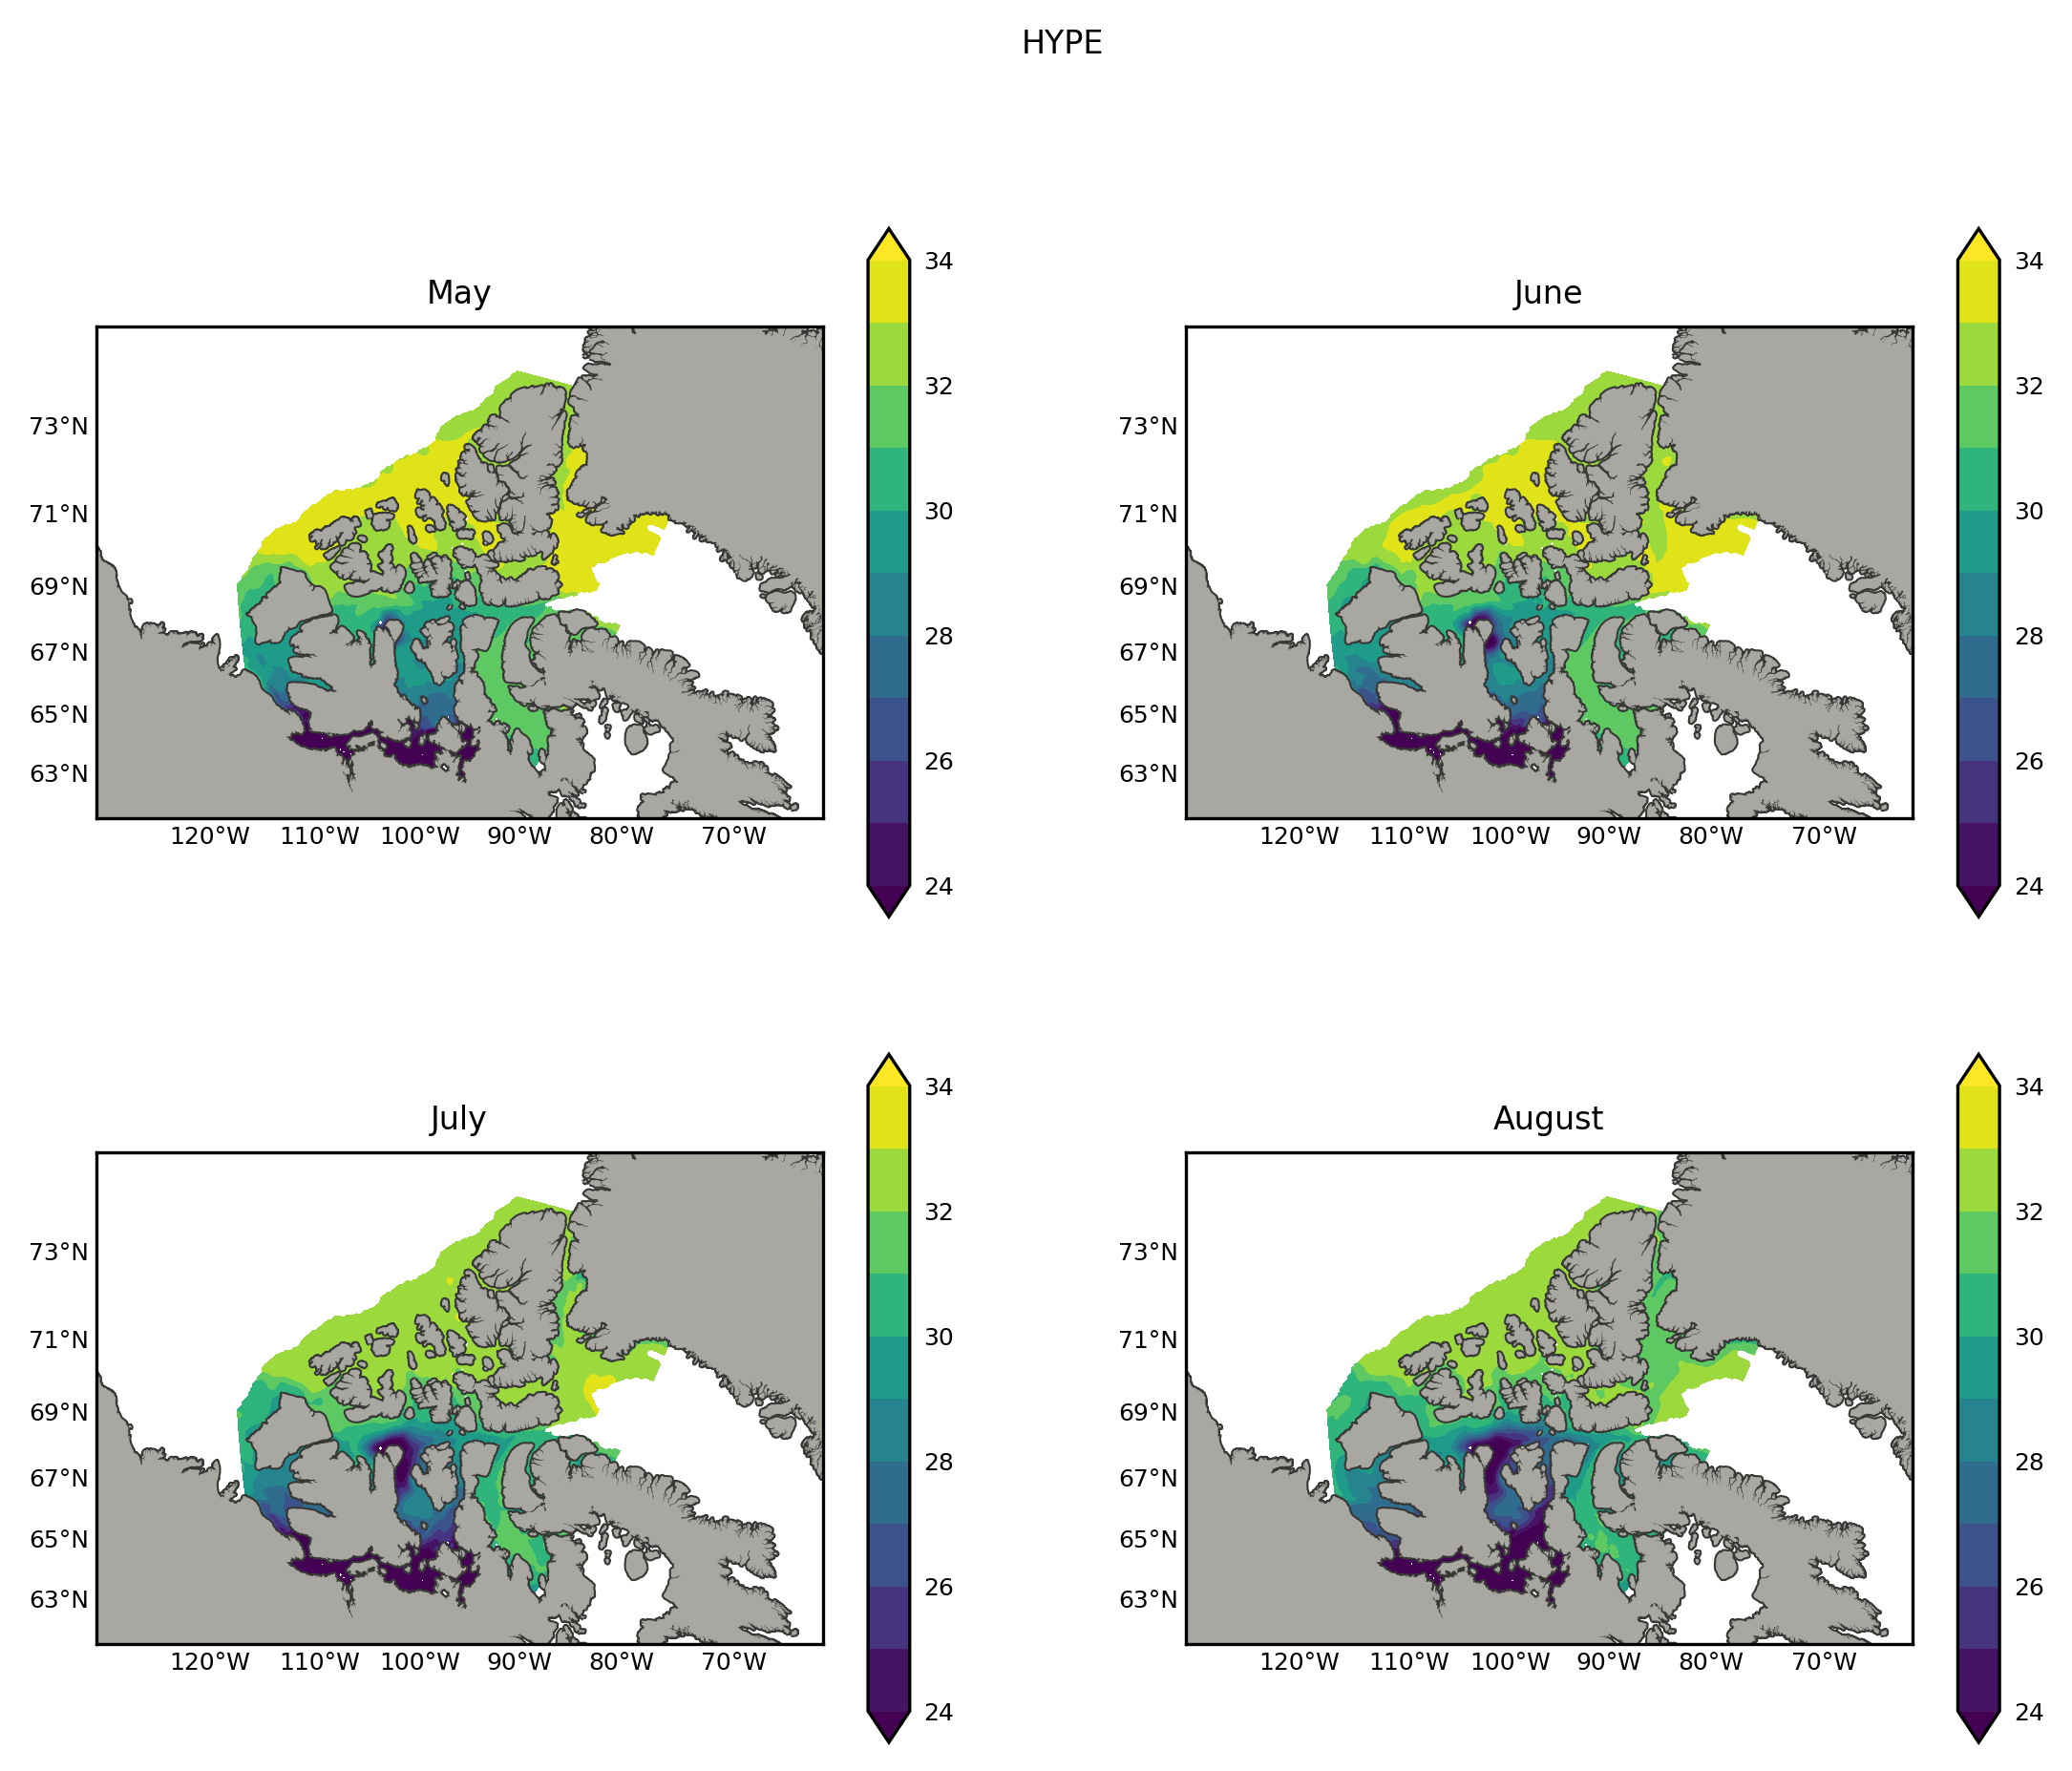

In [51]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_ANHA4, y_ANHA4 = proj1(ANHA4_lon_ma, ANHA4_lat_ma)

for ind, axis in enumerate(ax.ravel()):
    CS2 = proj1.contourf(x_ANHA4, y_ANHA4, np.ma.mean(HYPE_salinity_series_ma0[ind,0:17,:,:],axis=0), vmin=24, vmax=34, extend='both', \
                        levels=[24,25,26,27,28,29,30,31,32,33,34], ax=axis)

    # Colorbars:
    axis.set_title(months[ind],fontsize=8)
    CBar1   = plt.colorbar(CS2, ax=axis, ticks=[20,22,24,26,28,30,32,34], aspect=15)
    CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
    
fig.suptitle('HYPE', fontsize=8)

Text(0.5, 0.98, 'Dai')

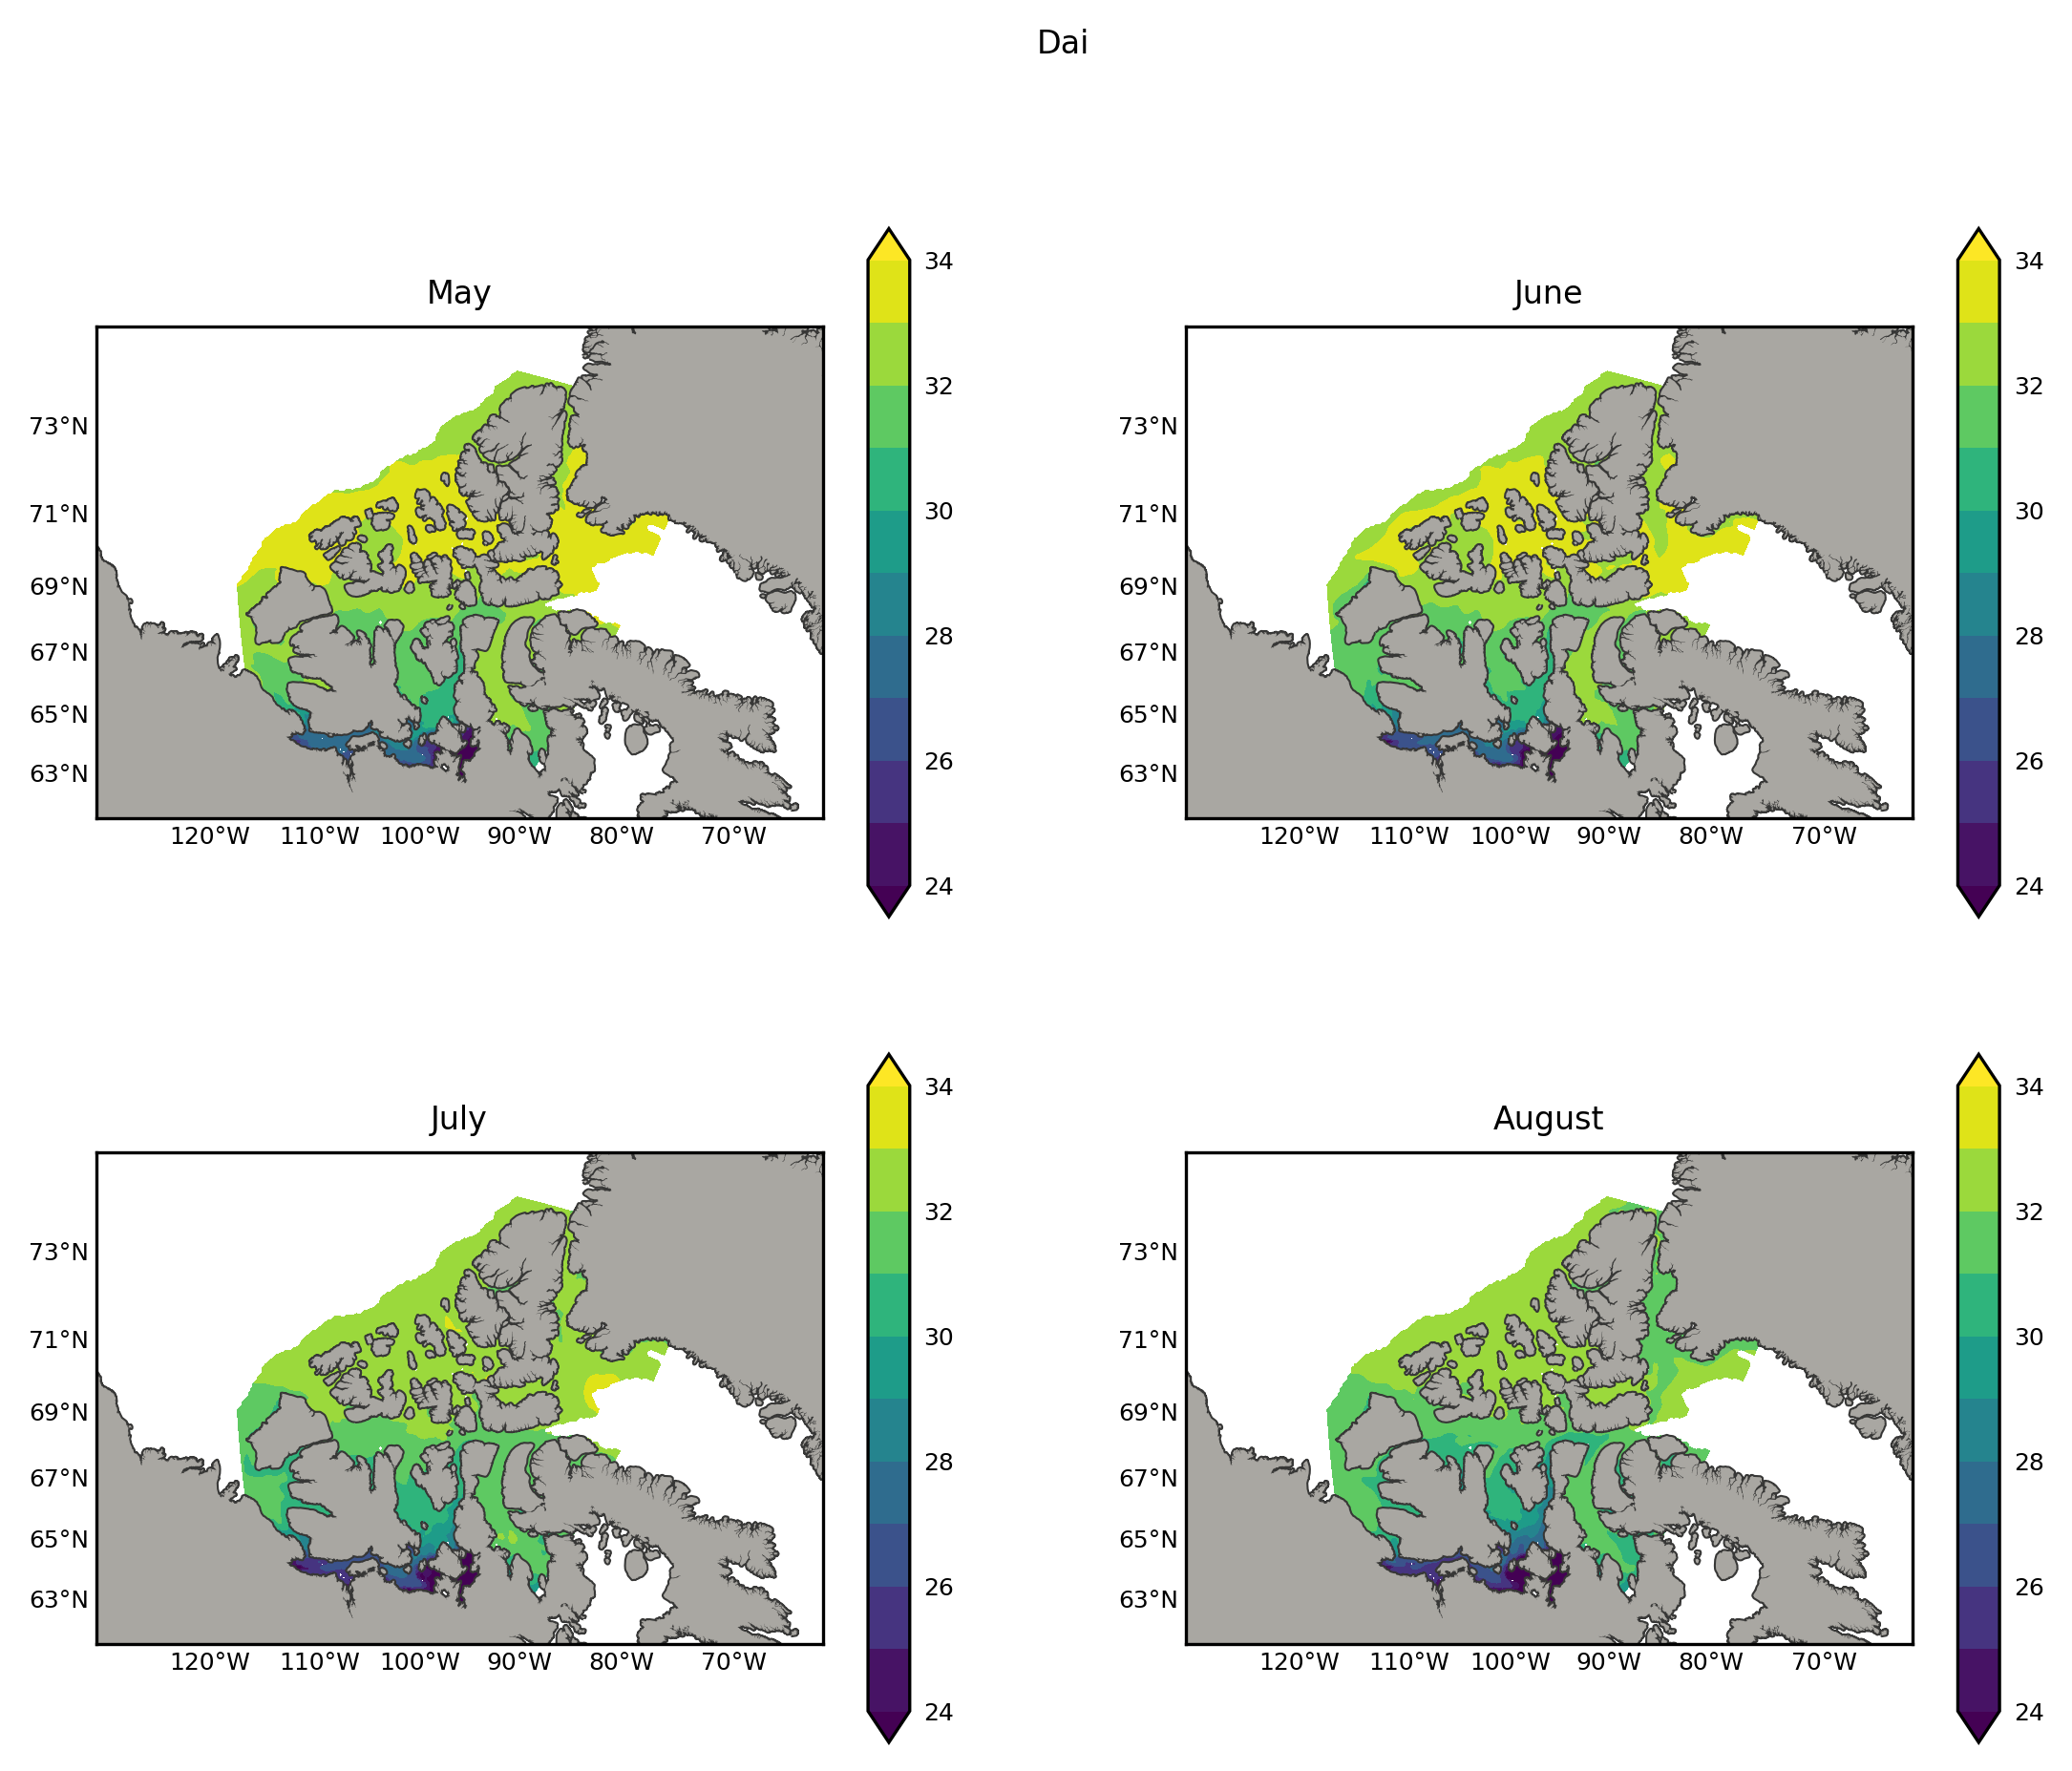

In [50]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_ANHA4, y_ANHA4 = proj1(ANHA4_lon_ma, ANHA4_lat_ma)

for ind, axis in enumerate(ax.ravel()):
    CS2 = proj1.contourf(x_ANHA4, y_ANHA4, np.ma.mean(Dai_salinity_series_ma0[ind,0:17,:,:],axis=0), vmin=24, vmax=34, extend='both', \
                        levels=[24,25,26,27,28,29,30,31,32,33,34], ax=axis)

    # Colorbars:
    axis.set_title(months[ind],fontsize=8) 
    CBar1   = plt.colorbar(CS2, ax=axis, ticks=[20,22,24,26,28,30,32,34], aspect=15)
    CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
    
fig.suptitle('Dai', fontsize=8)

### Side-by-side comparison

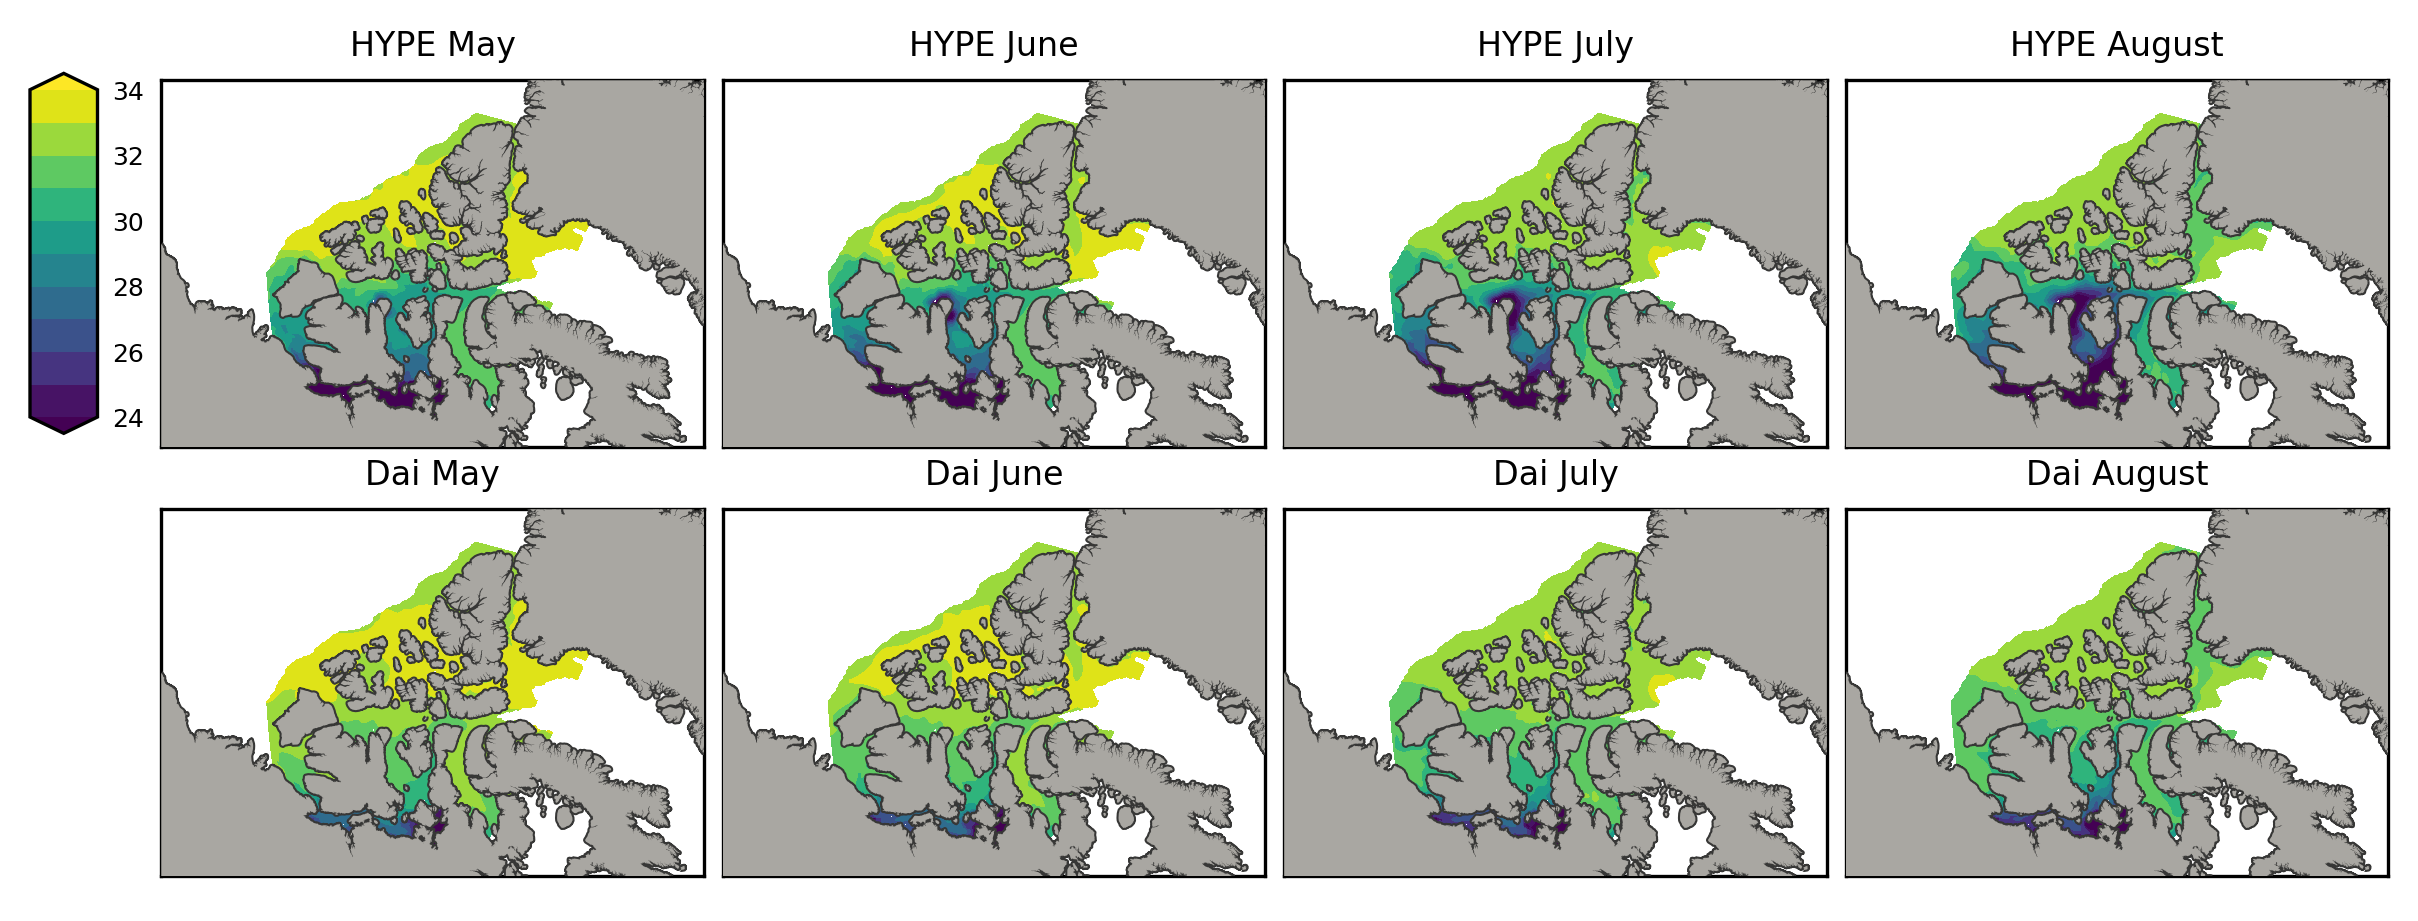

In [66]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/side-by-side-CAA.pickle','rb'))

#---------------------
x_ANHA4, y_ANHA4 = proj1(ANHA4_lon_ma, ANHA4_lat_ma)

for ind, axis in enumerate(ax[0,:].ravel()):
    CS1 = proj1.contourf(x_ANHA4, y_ANHA4, np.ma.mean(HYPE_salinity_series_ma0[ind,0:17,:,:],axis=0), vmin=24, vmax=34, extend='both', \
                        levels=np.arange(24,35,1), ax=axis)

    axis.set_title(f'HYPE {months[ind]}',fontsize=8)
    
for ind, axis in enumerate(ax[1,:].ravel()):
    CS2 = proj1.contourf(x_ANHA4, y_ANHA4, np.ma.mean(Dai_salinity_series_ma0[ind,0:17,:,:],axis=0), vmin=24, vmax=34, extend='both', \
                        levels=np.arange(24,35,1), ax=axis)

    axis.set_title(f'Dai {months[ind]}',fontsize=8)

cbaxes  = fig.add_axes([-0.05, 0.55, 0.03, 0.4])
CBar2   = plt.colorbar(CS2, cax=cbaxes, ticks=np.arange(20,36,2), aspect=15, shrink=0.6)
CBar2.ax.tick_params(axis='y', length=0, labelsize=6)

Victoria Island NE drainage looks a bit weird (Nanook river area?)

https://en.wikipedia.org/wiki/Victoria_Island#/media/File:Victoria_topo.png